<h1>PERSONALIZED NEWS RECOMMENDATION SYSTEM</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader
from surprise import SVD, KNNBasic
from gensim.models import Word2Vec
import tensorflow as tf
import gc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, LSTM, Dense, Dot, Activation
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy
from sklearn.metrics import roc_auc_score, average_precision_score, ndcg_score
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [2]:
news_columns = [
    'news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'
]

In [3]:
news = pd.read_csv('news.tsv', sep='\t', names=news_columns)

In [4]:
news.head()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [5]:
news.tail()

,news_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
51277,N16909,weather,weathertopstories,"Adapting, Learning And Soul Searching: Reflect...",Woolsey Fire Anniversary: A community is forev...,https://assets.msn.com/labs/mind/BBWzQJK.html,"[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid...","[{""Label"": ""Woolsey Fire"", ""Type"": ""N"", ""Wikid..."
51278,N47585,lifestyle,lifestylefamily,Family says 13-year-old Broadway star died fro...,NaN,https://assets.msn.com/labs/mind/BBWzQYV.html,"[{""Label"": ""Broadway theatre"", ""Type"": ""F"", ""W...",[]
51279,N7482,sports,more_sports,St. Dominic soccer player tries to kick cancer...,"Sometimes, what happens on the sidelines can b...",https://assets.msn.com/labs/mind/BBWzQnK.html,[],[]
51280,N34418,sports,soccer_epl,How the Sounders won MLS Cup,"Mark, Jeremiah and Casey were so excited they ...",https://assets.msn.com/labs/mind/BBWzQuK.html,"[{""Label"": ""MLS Cup"", ""Type"": ""U"", ""WikidataId...",[]
51281,N44276,autos,autossports,Best Sports Car Deals for October,NaN,https://assets.msn.com/labs/mind/BBy5rVe.html,"[{""Label"": ""Peugeot RCZ"", ""Type"": ""V"", ""Wikida...",[]


In [6]:
news.shape

(51282, 8)

In [7]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   news_id            51282 non-null  object
 1   category           51282 non-null  object
 2   subcategory        51282 non-null  object
 3   title              51282 non-null  object
 4   abstract           48616 non-null  object
 5   url                51282 non-null  object
 6   title_entities     51279 non-null  object
 7   abstract_entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


In [8]:
behaviors_columns = [
    'impression_id', 'user_id', 'time', 'history', 'impressions'
]

In [9]:
behaviors = pd.read_csv('behaviors.tsv', sep='\t', names=behaviors_columns)

In [10]:
behaviors.head()

,impression_id,user_id,time,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [11]:
behaviors.tail()

,impression_id,user_id,time,history,impressions
156960,156961,U21593,11/14/2019 10:24:05 PM,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...
156961,156962,U10123,11/13/2019 6:57:04 AM,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...
156962,156963,U75630,11/14/2019 10:58:13 AM,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...
156963,156964,U44625,11/13/2019 2:57:02 PM,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...
156964,156965,U64800,11/14/2019 3:25:49 PM,N22997 N48742,N61233-0 N33828-1 N19661-0 N41934-0


In [12]:
behaviors.shape

(156965, 5)

In [13]:
behaviors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 entries, 0 to 156964
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   impression_id  156965 non-null  int64 
 1   user_id        156965 non-null  object
 2   time           156965 non-null  object
 3   history        153727 non-null  object
 4   impressions    156965 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.0+ MB


In [14]:
news.isnull().sum()

news_id                 0
category                0
subcategory             0
title                   0
abstract             2666
url                     0
title_entities          3
abstract_entities       4
dtype: int64

In [15]:
behaviors.isnull().sum()

impression_id       0
user_id             0
time                0
history          3238
impressions         0
dtype: int64

In [16]:
news['abstract'] = news['abstract'].fillna('')

In [17]:
behaviors['history'] = behaviors['history'].fillna('')

In [18]:
news['full_text'] = news['title'] + ' ' + news['abstract']

In [19]:
news['category'].value_counts()

category
news             15774
sports           14510
finance           3107
foodanddrink      2551
lifestyle         2479
travel            2350
video             2068
weather           2048
health            1885
autos             1639
tv                 889
music              769
movies             606
entertainment      587
kids                17
middleeast           2
northamerica         1
Name: count, dtype: int64

In [20]:
news['category'].nunique()

17

In [21]:
news['subcategory'].value_counts()

subcategory
newsus                    6564
football_nfl              5420
newspolitics              2826
newscrime                 2254
weathertopstories         2047
                          ... 
newsvideo                    1
travel                       1
lifestylehoroscopefish       1
baseball                     1
celebhub                     1
Name: count, Length: 264, dtype: int64

In [22]:
news['subcategory'].nunique()

264

In [23]:
behaviors['user_id'].value_counts()

user_id
U32146    62
U15740    44
U20833    41
U51286    40
U44201    40
          ..
U60416     1
U20588     1
U84385     1
U89164     1
U72015     1
Name: count, Length: 50000, dtype: int64

In [24]:
behaviors['user_id'].nunique()

50000

/var/folders/__/bmtzjnxn039f2s779sjs1hhh0000gn/T/ipykernel_93012/1497813024.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='category', data=news, order=news['category'].value_counts().index, palette='viridis')


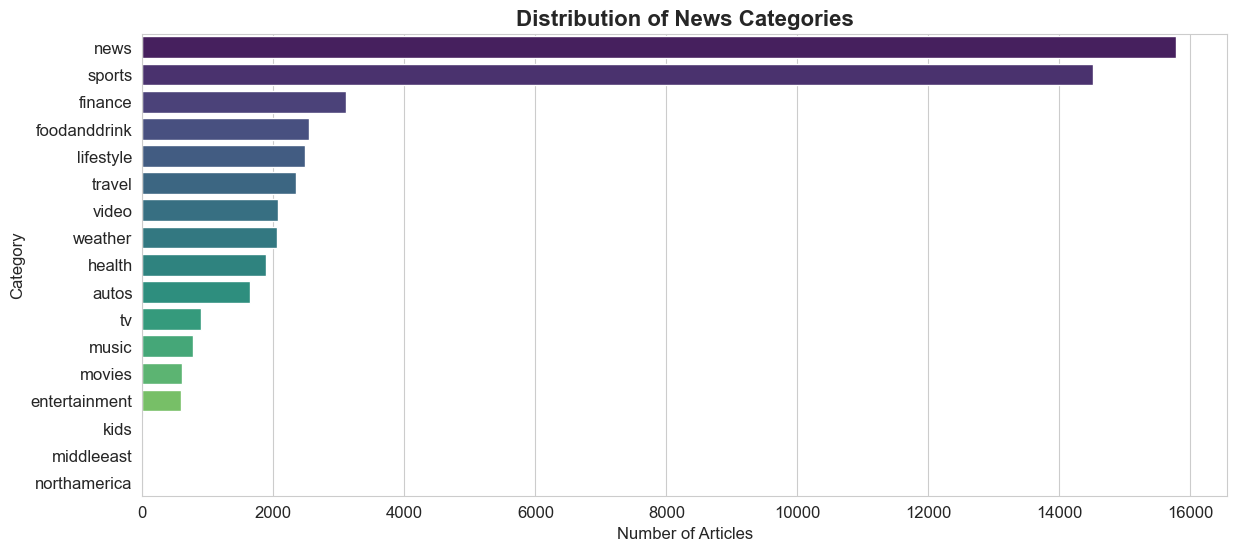

In [25]:
plt.figure(figsize=(14, 6))
sns.countplot(y='category', data=news, order=news['category'].value_counts().index, palette='viridis')
plt.title('Distribution of News Categories', fontsize=16, fontweight='bold')
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.show()

/var/folders/__/bmtzjnxn039f2s779sjs1hhh0000gn/T/ipykernel_93012/2802514530.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='subcategory', data=news[news['subcategory'].isin(top_subcats)], order=top_subcats, palette='magma')


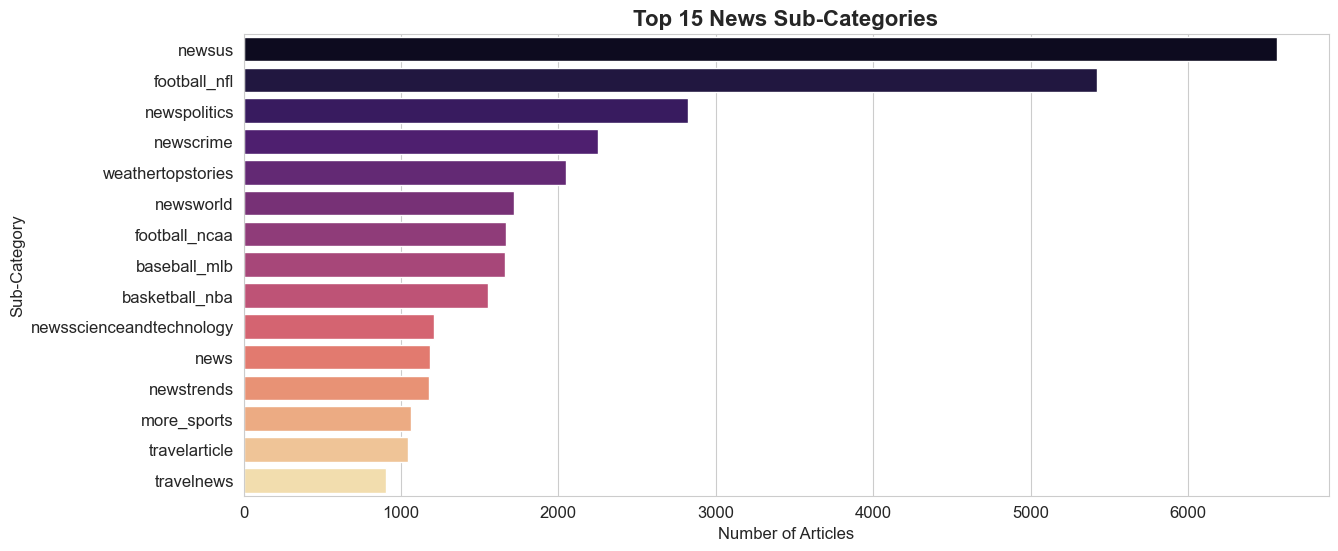

In [26]:
plt.figure(figsize=(14, 6))
top_subcats = news['subcategory'].value_counts().nlargest(15).index
sns.countplot(y='subcategory', data=news[news['subcategory'].isin(top_subcats)], order=top_subcats, palette='magma')
plt.title('Top 15 News Sub-Categories', fontsize=16, fontweight='bold')
plt.xlabel('Number of Articles')
plt.ylabel('Sub-Category')
plt.show()

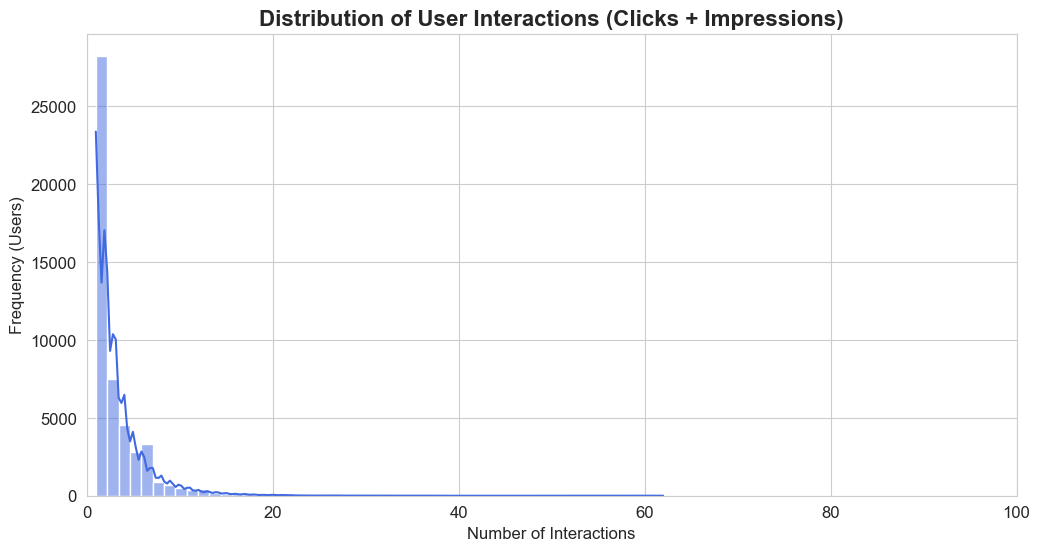

In [27]:
user_interaction_counts = behaviors['user_id'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(user_interaction_counts, bins=50, kde=True, color='royalblue')
plt.title('Distribution of User Interactions (Clicks + Impressions)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency (Users)')
plt.xlim(0, 100)
plt.show()

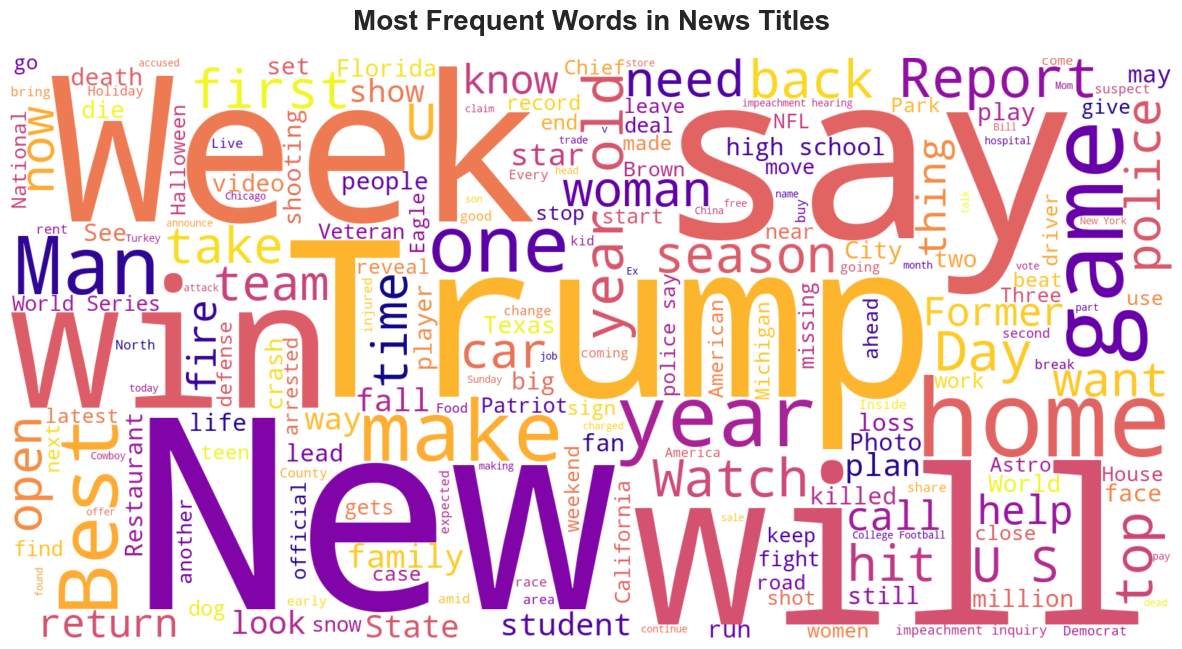

In [28]:
text = " ".join(title for title in news['title'])
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap='plasma').generate(text)

plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Frequent Words in News Titles', fontsize=20, fontweight='bold', pad=20)
plt.show()

In [29]:
parsed_interactions = []
for index, row in tqdm(behaviors.iterrows(), total=behaviors.shape[0]):
    user_id = row['user_id']
    time = row['time']
    history = row['history']
    impression_list = row['impressions'].split()
    for impression in impression_list:
        parts = impression.split('-')
        news_id = parts[0]
        clicked = int(parts[1])
        parsed_interactions.append(
            {
                'user_id': user_id,
                'news_id': news_id,
                'clicked': clicked,
                'time': time,
                'history': history
            }
        )

100%|██████████| 156965/156965 [00:06<00:00, 23600.64it/s]


In [30]:
interacions = pd.DataFrame(parsed_interactions)

In [31]:
interacions.head()

,user_id,news_id,clicked,time,history
0,U13740,N55689,1,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...
1,U13740,N35729,0,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...
2,U91836,N20678,0,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...
3,U91836,N39317,0,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...
4,U91836,N58114,0,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...


In [32]:
interacions.shape

(5843444, 5)

In [33]:
interacions['time'] = pd.to_datetime(interacions['time'], format='%m/%d/%Y %I:%M:%S %p')

In [34]:
interacions.sort_values(by='time', inplace=True)

In [35]:
interacions.reset_index(drop=True, inplace=True)

In [36]:
interacions.head()

,user_id,news_id,clicked,time,history
0,U65916,N57099,0,2019-11-09 00:00:19,N51706 N40767 N12096 N9798 N38802 N54827 N5780...
1,U65916,N50329,0,2019-11-09 00:00:19,N51706 N40767 N12096 N9798 N38802 N54827 N5780...
2,U65916,N20602,0,2019-11-09 00:00:19,N51706 N40767 N12096 N9798 N38802 N54827 N5780...
3,U65916,N18546,0,2019-11-09 00:00:19,N51706 N40767 N12096 N9798 N38802 N54827 N5780...
4,U65916,N6868,0,2019-11-09 00:00:19,N51706 N40767 N12096 N9798 N38802 N54827 N5780...


In [37]:
interacions.tail()

,user_id,news_id,clicked,time,history
5843439,U82996,N46917,0,2019-11-14 23:59:13,N39556 N22279 N56461 N33393 N6233 N33617 N4943...
5843440,U82996,N27737,0,2019-11-14 23:59:13,N39556 N22279 N56461 N33393 N6233 N33617 N4943...
5843441,U82996,N6837,0,2019-11-14 23:59:13,N39556 N22279 N56461 N33393 N6233 N33617 N4943...
5843442,U82996,N61233,0,2019-11-14 23:59:13,N39556 N22279 N56461 N33393 N6233 N33617 N4943...
5843443,U82996,N14478,0,2019-11-14 23:59:13,N39556 N22279 N56461 N33393 N6233 N33617 N4943...


In [38]:
split = int(len(interacions)*0.8)

In [39]:
train = interacions.iloc[:split]
test = interacions.iloc[split:]

In [40]:
len(interacions)

5843444

In [41]:
len(train)

4674755

In [42]:
len(test)

1168689

In [43]:
train['clicked'].value_counts(normalize=True)

clicked
0    0.959084
1    0.040916
Name: proportion, dtype: float64

In [44]:
train_positives = train[train['clicked'] == 1]
train_negatives = train[train['clicked'] == 0]

In [45]:
num_positives = len(train_positives)

In [46]:
num_positives

191271

In [47]:
len(train_negatives)

4483484

In [48]:
train_negatives_sampled = train_negatives.sample(n=num_positives, random_state=42)

In [49]:
train_balanced = pd.concat([train_positives, train_negatives_sampled])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [50]:
len(train_balanced)

382542

In [51]:
train = train_balanced.copy()

In [52]:
train['clicked'].value_counts(normalize=True)

clicked
0    0.5
1    0.5
Name: proportion, dtype: float64

## POPULARITY BASED RECOMMENDER (Baseline)

In [53]:
popular_articles = train[train['clicked'] == 1]['news_id'].value_counts()

In [54]:
popular_articles_data = popular_articles.reset_index()

In [55]:
popular_articles_data.columns = ['news_id', 'click_count']

In [56]:
popular_articles_data.head()

,news_id,click_count
0,N55689,4316
1,N35729,3346
2,N33619,3246
3,N53585,2835
4,N63970,2578


In [57]:
test_with_popularity = test.merge(popular_articles_data, on='news_id', how='left')

In [58]:
test_with_popularity['click_count'] = test_with_popularity['click_count'].fillna(0)

In [59]:
test_with_popularity[['user_id', 'news_id', 'clicked', 'click_count']].head()

,user_id,news_id,clicked,click_count
0,U47606,N50107,0,31.0
1,U47606,N60272,0,313.0
2,U47606,N58086,0,6.0
3,U47606,N38215,0,315.0
4,U47606,N61787,1,46.0


In [60]:
evaluation_results = {}

In [61]:
def calculate_metrics(group):
    if len(group['clicked'].unique()) < 2:
        return np.nan, np.nan, np.nan
    
    y_true = group['clicked'].values
    y_score = group['score'].values

    k_5 = min(5, len(y_true))
    k_10 = min(10, len(y_true))

    y_true_2d = [y_true]
    y_score_2d = [y_score]

    auc = roc_auc_score(y_true, y_score)
    map_score = average_precision_score(y_true, y_score)

    ndcg_at_5 = ndcg_score(y_true_2d, y_score_2d, k=k_5)
    ndcg_at_10 = ndcg_score(y_true_2d, y_score_2d, k=k_10)

    return auc, map_score, ndcg_at_5, ndcg_at_10

In [62]:
pop_test_df = test_with_popularity.rename(columns={'click_count': 'score'})

In [63]:
pop_metrics = pop_test_df.groupby(['user_id', 'time']).apply(calculate_metrics)

/var/folders/__/bmtzjnxn039f2s779sjs1hhh0000gn/T/ipykernel_93012/2861753001.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pop_metrics = pop_test_df.groupby(['user_id', 'time']).apply(calculate_metrics)


In [64]:
pop_metrics.dropna(inplace=True)

In [65]:
pop_metrics_data = pd.DataFrame(pop_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [66]:
evaluation_results['Popularity'] = pop_metrics_data.mean()

In [67]:
evaluation_results

{'Popularity': AUC        0.488288
 MAP        0.182673
 NDCG@5     0.198044
 NDCG@10    0.261494
 dtype: float64}

## CONTENT-BASED FILTERING

### TF-IDF

In [68]:
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=20000,
    min_df=5
)

In [69]:
tfidf_data = tfidf.fit_transform(news['full_text'])

In [70]:
tfidf_data.shape

(51282, 18646)

In [71]:
news_id_to_index = pd.Series(news.index, index=news['news_id'])

In [72]:
sample_user_id = train['user_id'].iloc[0]

In [73]:
user_history_ids = train[
    (train['user_id'] == sample_user_id) & (train['clicked'] == 1)
]['news_id'].unique()

In [74]:
sample_user_id

'U62731'

In [75]:
if len(user_history_ids) > 0:
    last_liked_article_id = user_history_ids[-1]
    last_liked_article_index = news_id_to_index[last_liked_article_id]
    article_vector = tfidf_data[last_liked_article_index]
    cosine = cosine_similarity(article_vector, tfidf_data)

    similar_article_scores = list(enumerate(cosine[0]))
    sorted_scores = sorted(similar_article_scores, key=lambda x: x[1], reverse=True)[1:11]

    similar_article_indices = [i[0] for i in sorted_scores]
    recommended_news_ids = news.iloc[similar_article_indices]['news_id']

    print('Last liked article: ', last_liked_article_id)
    print('Recommendations:\n', recommended_news_ids)
else:
    print(f'User {sample_user_id} has no click history in train set.')


Last liked article:  N18423
Recommendations:
 36288     N3579
47535     N6190
42399    N27885
32361    N63035
37760    N44729
47201    N50115
46314    N31869
4752     N13318
43035    N47248
19281    N15592
Name: news_id, dtype: object


In [76]:
tqdm.pandas(desc='Calculating Content Scores')

In [77]:
def calculate_content_score(row):
    history_ids = row['history'].split()
    candidate_id = row['news_id']
    if not history_ids:
        return 0.0
    history_indices = [news_id_to_index.get(nid) for nid in history_ids]
    history_indices = [i for i in history_indices if i is not None]
    if not history_indices:
        return 0.0
    history_vectors = tfidf_data[history_indices]
    user_profile = np.asarray(np.mean(history_vectors, axis=0))
    candidate_index = news_id_to_index.get(candidate_id)
    if candidate_index is None:
        return 0.0
    candidate_vector = tfidf_data[candidate_index]
    score = cosine_similarity(user_profile, candidate_vector)[0][0]
    return score

In [78]:
cb_test_data = test.copy()

In [79]:
cb_test_data['score'] = cb_test_data.progress_apply(calculate_content_score, axis=1)

Calculating Content Scores: 100%|██████████| 1168689/1168689 [05:45<00:00, 3383.95it/s]


In [80]:
cb_metrics = cb_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)

/var/folders/__/bmtzjnxn039f2s779sjs1hhh0000gn/T/ipykernel_93012/2169323006.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cb_metrics = cb_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)


In [81]:
cb_metrics.dropna(inplace=True)

In [82]:
cb_metrics_data = pd.DataFrame(cb_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [83]:
cb_mean_metrics = cb_metrics_data.mean()

In [84]:
cb_mean_metrics

AUC        0.593417
MAP        0.285850
NDCG@5     0.296274
NDCG@10    0.352968
dtype: float64

In [85]:
evaluation_results['Content-Based'] = cb_mean_metrics

In [86]:
evaluation_results

{'Popularity': AUC        0.488288
 MAP        0.182673
 NDCG@5     0.198044
 NDCG@10    0.261494
 dtype: float64,
 'Content-Based': AUC        0.593417
 MAP        0.285850
 NDCG@5     0.296274
 NDCG@10    0.352968
 dtype: float64}

### Word2Vec

In [87]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\w\s', '', text)
    return text.split()

In [88]:
tokenized_text = news['full_text'].apply(preprocess)

In [89]:
vector_size = 100

In [90]:
word2vec_model = Word2Vec(
    sentences=tokenized_text,
    vector_size=vector_size,
    window=5,
    min_count=5,
    workers=4
)

In [91]:
def get_article_vector(tokens, model, vector_size):
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not word_vectors:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

In [92]:
article_vectors_w2v = np.array(
    [get_article_vector(doc, word2vec_model, vector_size) for doc in tokenized_text]
)

In [93]:
def calculate_content_score_w2v(row):
    history_ids = row['history'].split()
    candidate_id = row['news_id']
    if not history_ids:
        return 0.0
    history_indices = [news_id_to_index.get(nid) for nid in history_ids]
    history_indices = [i for i in history_indices if i is not None]
    if not history_indices:
        return 0.0
    history_vectors = article_vectors_w2v[history_indices]
    user_profile = np.mean(history_vectors, axis=0)
    candidate_index = news_id_to_index.get(candidate_id)
    if candidate_index is None:
        return 0.0
    candidate_vector = article_vectors_w2v[candidate_index]
    score = cosine_similarity(user_profile.reshape(1, -1), candidate_vector.reshape(1, -1))[0][0]
    return score

In [94]:
cb_w2v_test = test.copy()

In [95]:
cb_w2v_test['score'] = cb_w2v_test.progress_apply(calculate_content_score_w2v, axis=1)

Calculating Content Scores:   0%|          | 0/1168689 [00:00<?, ?it/s]

Calculating Content Scores: 100%|██████████| 1168689/1168689 [02:28<00:00, 7877.36it/s]


In [96]:
cb_w2v_metrics = cb_w2v_test.groupby(['user_id', 'time']).apply(calculate_metrics)

/var/folders/__/bmtzjnxn039f2s779sjs1hhh0000gn/T/ipykernel_93012/619245419.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cb_w2v_metrics = cb_w2v_test.groupby(['user_id', 'time']).apply(calculate_metrics)


In [97]:
cb_w2v_metrics.dropna(inplace=True)

In [98]:
cb_w2v_metrics_data = pd.DataFrame(cb_w2v_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [99]:
cb_w2v_mean_metrics = cb_w2v_metrics_data.mean()

In [100]:
cb_w2v_mean_metrics

AUC        0.504323
MAP        0.134674
NDCG@5     0.207861
NDCG@10    0.268064
dtype: float64

In [101]:
evaluation_results['Content-Based (W2V)'] = cb_w2v_mean_metrics

In [102]:
evaluation_results

{'Popularity': AUC        0.488288
 MAP        0.182673
 NDCG@5     0.198044
 NDCG@10    0.261494
 dtype: float64,
 'Content-Based': AUC        0.593417
 MAP        0.285850
 NDCG@5     0.296274
 NDCG@10    0.352968
 dtype: float64,
 'Content-Based (W2V)': AUC        0.504323
 MAP        0.134674
 NDCG@5     0.207861
 NDCG@10    0.268064
 dtype: float64}

## COLLABORATIVE FILTERING

### SVD

In [103]:
reader = Reader(rating_scale=(0, 1))

In [104]:
svd_train_data = Dataset.load_from_df(
    train[['user_id', 'news_id', 'clicked']],
    reader
)

In [105]:
trainset = svd_train_data.build_full_trainset()

In [106]:
model_svd = SVD(
    n_factors = 100,
    n_epochs = 20,
    lr_all = 0.005,
    reg_all = 0.02,
    verbose = True
)

In [107]:
model_svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [108]:
sample_test_interaction = test.iloc[0]

In [109]:
user_id = sample_test_interaction['user_id']
news_id = sample_test_interaction['news_id']
true_click = sample_test_interaction['clicked']

In [110]:
prediction = model_svd.predict(uid=user_id, iid=news_id)

In [111]:
print(f'User: {user_id} on {news_id}: ')
print(f'Predicted click probability: {prediction}')
print(f'True Click: {true_click}')

User: U47606 on N50107: 
Predicted click probability: user: U47606     item: N50107     r_ui = None   est = 0.36   {'was_impossible': False}
True Click: 0


In [112]:
svd_scores = []
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    prediction = model_svd.predict(uid=row['user_id'], iid=row['news_id'])
    svd_scores.append(prediction.est)

100%|██████████| 1168689/1168689 [00:15<00:00, 73530.14it/s]


In [113]:
svd_test_data = test.copy()

In [114]:
svd_test_data['score'] = svd_scores

In [115]:
svd_metrics = svd_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)

/var/folders/__/bmtzjnxn039f2s779sjs1hhh0000gn/T/ipykernel_93012/3277718055.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  svd_metrics = svd_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)


In [116]:
svd_metrics.dropna(inplace=True)

In [117]:
svd_metrics_data = pd.DataFrame(svd_metrics.to_list(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [118]:
svd_mean_metrics = svd_metrics_data.mean()

In [119]:
svd_mean_metrics

AUC        0.555113
MAP        0.205877
NDCG@5     0.230172
NDCG@10    0.292118
dtype: float64

In [120]:
evaluation_results['SVD'] = svd_mean_metrics

In [121]:
evaluation_results

{'Popularity': AUC        0.488288
 MAP        0.182673
 NDCG@5     0.198044
 NDCG@10    0.261494
 dtype: float64,
 'Content-Based': AUC        0.593417
 MAP        0.285850
 NDCG@5     0.296274
 NDCG@10    0.352968
 dtype: float64,
 'Content-Based (W2V)': AUC        0.504323
 MAP        0.134674
 NDCG@5     0.207861
 NDCG@10    0.268064
 dtype: float64,
 'SVD': AUC        0.555113
 MAP        0.205877
 NDCG@5     0.230172
 NDCG@10    0.292118
 dtype: float64}

In [122]:
pd.DataFrame(evaluation_results).T

,AUC,MAP,NDCG@5,NDCG@10
Popularity,0.488288,0.182673,0.198044,0.261494
Content-Based,0.593417,0.285850,0.296274,0.352968
Content-Based (W2V),0.504323,0.134674,0.207861,0.268064
SVD,0.555113,0.205877,0.230172,0.292118


## HYBRID NEURAL MODEL

In [123]:
vector_size = 100

In [124]:
max_history_length = 20

In [125]:
batch_size = 1024

In [126]:
original_w2v_matrix = article_vectors_w2v

In [127]:
num_articles = original_w2v_matrix.shape[0]

In [128]:
embedding_matrix = np.zeros((num_articles + 1, vector_size))

In [129]:
embedding_matrix[1:] = original_w2v_matrix

In [130]:
original_w2v_matrix.shape

(51282, 100)

In [131]:
embedding_matrix.shape

(51283, 100)

In [132]:
news_id_to_index_padded = {
    news_id: index + 1 for news_id, index in news_id_to_index.items()
}

In [133]:
def create_sequences(df, padded_index, max_len):
    histories = []
    candidates = []
    labels = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Creating Sequences"):
        history_ids = row['history'].split()
        history_indices = [padded_index.get(nid) for nid in history_ids if padded_index.get(nid) is not None]
        padded_history = pad_sequences([history_indices], maxlen=max_len, padding='pre', truncating='pre')[0]
        candidate_index = padded_index.get(row['news_id'])
        label = row['clicked']
        if candidate_index is not None:
            histories.append(padded_history)
            candidates.append(candidate_index)
            labels.append(label)
    return np.array(histories), np.array(candidates), np.array(labels)

In [134]:
X_train_hist, X_train_cand, y_train = create_sequences(
    train, 
    news_id_to_index_padded, 
    max_history_length
)

Creating Sequences: 100%|██████████| 382542/382542 [00:08<00:00, 44670.64it/s]


In [135]:
X_test_hist, X_test_cand, y_test = create_sequences(
    test, 
    news_id_to_index_padded, 
    max_history_length
)

Creating Sequences: 100%|██████████| 1168689/1168689 [00:25<00:00, 46093.61it/s]


In [136]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"History_Input": X_train_hist, "Candidate_Input": X_train_cand},
        y_train
    )
)

2025-12-03 23:27:59.173148: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-12-03 23:27:59.187329: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-03 23:27:59.193013: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-03 23:27:59.193767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-03 23:27:59.194560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [137]:
num_train_samples = len(X_train_hist)

In [138]:
num_val_samples = int(num_train_samples * 0.1)

In [139]:
num_train_only_samples = num_train_samples - num_val_samples

In [140]:
train_dataset = train_dataset.shuffle(num_train_samples, reshuffle_each_iteration=False)

In [141]:
train_pipeline = (
    train_dataset.take(num_train_only_samples)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [142]:
val_pipeline = (
    train_dataset.skip(num_train_only_samples)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

In [143]:
test_pipeline = tf.data.Dataset.from_tensor_slices(
    (
        {"History_Input": X_test_hist, "Candidate_Input": X_test_cand},
        y_test
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [144]:
num_train_only_samples

344288

In [145]:
num_val_samples

38254

In [146]:
tf.keras.backend.clear_session()

In [147]:
article_embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    trainable=False,
    mask_zero=True
)

In [148]:
history_input = Input(shape=(max_history_length,), name="History_Input")

In [149]:
candidate_input = Input(shape=(1,), name="Candidate_Input")

In [150]:
history_vectors = article_embedding_layer(history_input)

In [151]:
candidate_vector_sequential = article_embedding_layer(candidate_input)

In [152]:
candidate_vector = tf.keras.layers.Flatten()(candidate_vector_sequential)

/Users/ravisankarchengannagari/Desktop/Emotion Classification/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


### Simple RNN

In [153]:
rnn_output = SimpleRNN(vector_size, name="RNN_Encoder")(history_vectors)

In [154]:
dot_product = Dot(axes=1, name="Dot_Product")([rnn_output, candidate_vector])

In [155]:
dot_product = tf.keras.layers.Flatten()(dot_product)

In [156]:
output = Activation('sigmoid', name="Click_Probability")(dot_product)

In [157]:
model = Model(inputs=[history_input, candidate_input], outputs=[output])

In [158]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['auc']
)

In [159]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ History_Input       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Candidate_Input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │  5,128,300 │ History_Input[0]… │
│ (Embedding)         │                   │            │ Candidate_Input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ History_Input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RNN_Encoder         │ (None, 100)       │     20,100 │ embedding[0][0],  │
│ (SimpleRNN)         │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100)       │          0 │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dot_Product (Dot)   │ (None, 1)         │          0 │ RNN_Encoder[0][0… │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ Dot_Product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Click_Probability   │ (None, 1)         │          0 │ flatten_1[0][0]   │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,148,400 (19.64 MB)

 Trainable params: 20,100 (78.52 KB)

 Non-trainable params: 5,128,300 (19.56 MB)

In [160]:
len(tf.config.list_physical_devices('GPU'))

1

In [161]:
history = model.fit(
    train_pipeline,
    epochs=5,
    validation_data = val_pipeline,
    verbose=1
)

Epoch 1/5


2025-12-03 23:28:00.890752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


337/337 ━━━━━━━━━━━━━━━━━━━━ 80s 234ms/step - auc: 0.5260 - loss: 0.6909 - val_auc: 0.5321 - val_loss: 0.6903
Epoch 2/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 78s 232ms/step - auc: 0.5267 - loss: 0.6904 - val_auc: 0.5299 - val_loss: 0.6903
Epoch 3/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 79s 235ms/step - auc: 0.5256 - loss: 0.6903 - val_auc: 0.5277 - val_loss: 0.6902
Epoch 4/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 80s 235ms/step - auc: 0.5252 - loss: 0.6903 - val_auc: 0.5277 - val_loss: 0.6902
Epoch 5/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 80s 237ms/step - auc: 0.5254 - loss: 0.6903 - val_auc: 0.5282 - val_loss: 0.6902


In [162]:
def plot_training_history(history, model_name):
    acc = history.history['auc']
    val_acc = history.history['val_auc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-o', label='Training AUC')
    plt.plot(epochs, val_acc, 'r-o', label='Validation AUC')
    plt.title(f'{model_name}: Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title(f'{model_name}: Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

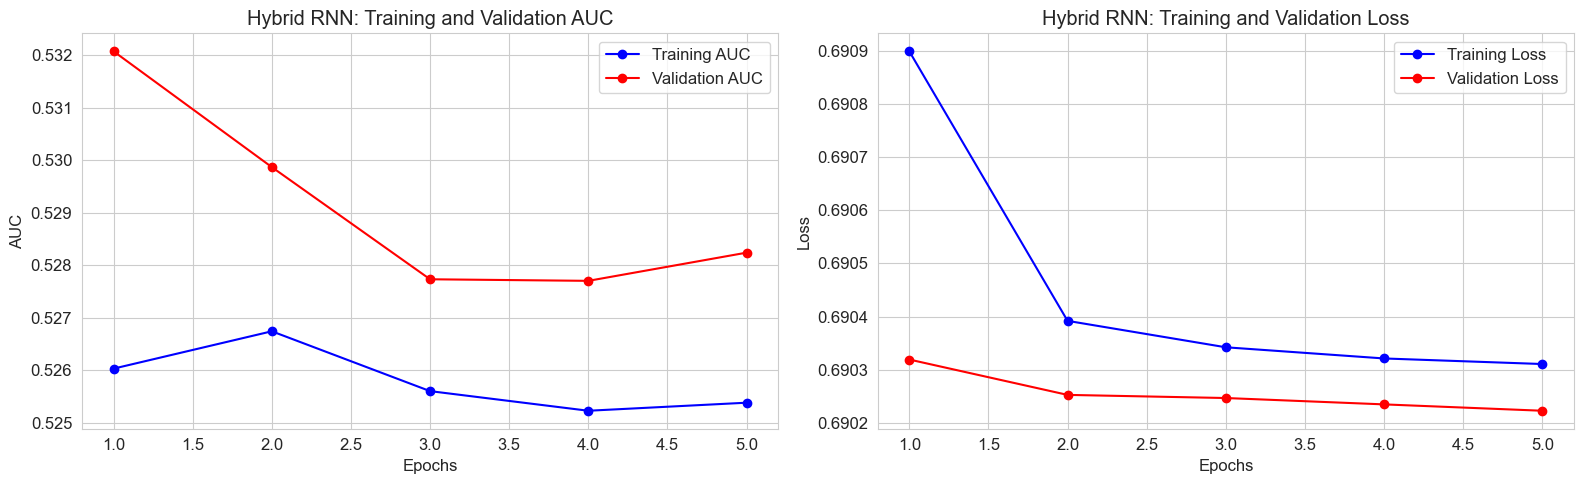

In [163]:
plot_training_history(history, "Hybrid RNN")

In [164]:
rnn_scores = model.predict(
    test_pipeline.map(lambda x, y: x),
    verbose=1
)

1142/1142 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step


In [165]:
test_indices_with_valid_candidates = [
    idx for idx, row in test.iterrows()
    if news_id_to_index_padded.get(row['news_id']) is not None
]

In [166]:
rnn_test_data = test.loc[test_indices_with_valid_candidates].copy()

In [167]:
rnn_test_data['score'] = rnn_scores.flatten()

In [168]:
rnn_metrics = rnn_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)

/var/folders/__/bmtzjnxn039f2s779sjs1hhh0000gn/T/ipykernel_93012/1849621626.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rnn_metrics = rnn_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)


In [169]:
rnn_metrics.dropna(inplace=True)

In [170]:
rnn_metrics_data = pd.DataFrame(rnn_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [171]:
rnn_mean_metrics = rnn_metrics_data.mean()

In [172]:
rnn_mean_metrics

AUC        0.503991
MAP        0.139351
NDCG@5     0.210431
NDCG@10    0.269755
dtype: float64

In [173]:
evaluation_results['Hybrid RNN'] = rnn_mean_metrics

In [174]:
evaluation_results

{'Popularity': AUC        0.488288
 MAP        0.182673
 NDCG@5     0.198044
 NDCG@10    0.261494
 dtype: float64,
 'Content-Based': AUC        0.593417
 MAP        0.285850
 NDCG@5     0.296274
 NDCG@10    0.352968
 dtype: float64,
 'Content-Based (W2V)': AUC        0.504323
 MAP        0.134674
 NDCG@5     0.207861
 NDCG@10    0.268064
 dtype: float64,
 'SVD': AUC        0.555113
 MAP        0.205877
 NDCG@5     0.230172
 NDCG@10    0.292118
 dtype: float64,
 'Hybrid RNN': AUC        0.503991
 MAP        0.139351
 NDCG@5     0.210431
 NDCG@10    0.269755
 dtype: float64}

### LSTM

In [175]:
tf.keras.backend.clear_session()

In [176]:
article_embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    trainable=True,
    mask_zero=True
)

In [177]:
history_input = Input(shape=(max_history_length,), name="History_Input")
candidate_input = Input(shape=(1,), name="Candidate_Input")

In [178]:
history_vectors = article_embedding_layer(history_input)
candidate_vector_sequential = article_embedding_layer(candidate_input)
candidate_vector = tf.keras.layers.Flatten()(candidate_vector_sequential)

/Users/ravisankarchengannagari/Desktop/Emotion Classification/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [179]:
lstm_output = LSTM(vector_size, name="LSTM_Encoder", recurrent_dropout=0.001)(history_vectors)

In [180]:
dot_product = Dot(axes=1, name="Dot_Product")([lstm_output, candidate_vector])

In [181]:
dot_product = tf.keras.layers.Flatten()(dot_product)

In [182]:
output = Activation('sigmoid', name="Click_Probability")(dot_product)

In [183]:
model_lstm = Model(inputs=[history_input, candidate_input], outputs=[output])

In [184]:
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['auc']
)

In [185]:
model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ History_Input       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Candidate_Input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │  5,128,300 │ History_Input[0]… │
│ (Embedding)         │                   │            │ Candidate_Input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ History_Input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_Encoder (LSTM) │ (None, 100)       │     80,400 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100)       │          0 │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dot_Product (Dot)   │ (None, 1)         │          0 │ LSTM_Encoder[0][… │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ Dot_Product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Click_Probability   │ (None, 1)         │          0 │ flatten_1[0][0]   │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,208,700 (19.87 MB)

 Trainable params: 5,208,700 (19.87 MB)

 Non-trainable params: 0 (0.00 B)

In [186]:
history_lstm = model_lstm.fit(
    train_pipeline,
    epochs=5,
    validation_data=val_pipeline,
    verbose=1
)

Epoch 1/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 252s 742ms/step - auc: 0.6973 - loss: 0.6278 - val_auc: 0.7147 - val_loss: 0.6162
Epoch 2/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 250s 741ms/step - auc: 0.7258 - loss: 0.6081 - val_auc: 0.7149 - val_loss: 0.6163
Epoch 3/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 252s 747ms/step - auc: 0.7349 - loss: 0.5998 - val_auc: 0.7153 - val_loss: 0.6175
Epoch 4/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 254s 752ms/step - auc: 0.7443 - loss: 0.5908 - val_auc: 0.7159 - val_loss: 0.6185
Epoch 5/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 244s 722ms/step - auc: 0.7539 - loss: 0.5817 - val_auc: 0.7165 - val_loss: 0.6202


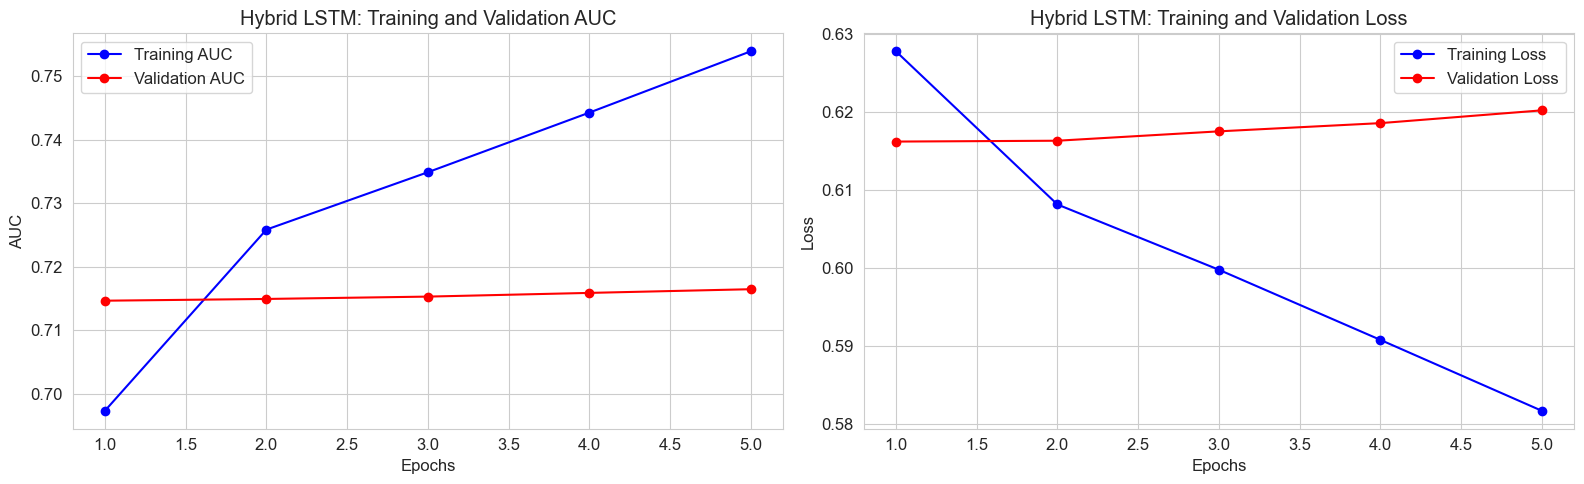

In [187]:
plot_training_history(history_lstm, "Hybrid LSTM")

In [188]:
lstm_scores = model_lstm.predict(
    test_pipeline.map(lambda x, y: x),
    verbose=1
)

1142/1142 ━━━━━━━━━━━━━━━━━━━━ 67s 59ms/step


In [189]:
lstm_test_data = test.loc[test_indices_with_valid_candidates].copy()

In [190]:
lstm_test_data['score'] = lstm_scores.flatten()

In [191]:
lstm_metrics = lstm_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)

/var/folders/__/bmtzjnxn039f2s779sjs1hhh0000gn/T/ipykernel_93012/3082903980.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lstm_metrics = lstm_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)


In [192]:
lstm_metrics.dropna(inplace=True)

In [193]:
lstm_metrics_data = pd.DataFrame(lstm_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [194]:
lstm_mean_metrics = lstm_metrics_data.mean()

In [195]:
lstm_mean_metrics

AUC        0.568548
MAP        0.228526
NDCG@5     0.241389
NDCG@10    0.304908
dtype: float64

In [196]:
evaluation_results['Hybrid LSTM'] = lstm_mean_metrics

In [197]:
evaluation_results

{'Popularity': AUC        0.488288
 MAP        0.182673
 NDCG@5     0.198044
 NDCG@10    0.261494
 dtype: float64,
 'Content-Based': AUC        0.593417
 MAP        0.285850
 NDCG@5     0.296274
 NDCG@10    0.352968
 dtype: float64,
 'Content-Based (W2V)': AUC        0.504323
 MAP        0.134674
 NDCG@5     0.207861
 NDCG@10    0.268064
 dtype: float64,
 'SVD': AUC        0.555113
 MAP        0.205877
 NDCG@5     0.230172
 NDCG@10    0.292118
 dtype: float64,
 'Hybrid RNN': AUC        0.503991
 MAP        0.139351
 NDCG@5     0.210431
 NDCG@10    0.269755
 dtype: float64,
 'Hybrid LSTM': AUC        0.568548
 MAP        0.228526
 NDCG@5     0.241389
 NDCG@10    0.304908
 dtype: float64}

### BI-LSTM

In [198]:
tf.keras.backend.clear_session()

In [199]:
early_stopping = EarlyStopping(
    monitor='val_auc', 
    mode='max',
    patience=1, 
    restore_best_weights=True,
    verbose=1
)

In [200]:
article_embedding_layer = Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    trainable=True,
    mask_zero=True
)

In [201]:
history_input = Input(shape=(max_history_length,), name="History_Input")
candidate_input = Input(shape=(1,), name="Candidate_Input")

In [202]:
history_vectors = article_embedding_layer(history_input)
candidate_vector_sequential = article_embedding_layer(candidate_input)
candidate_vector = tf.keras.layers.Flatten()(candidate_vector_sequential)

/Users/ravisankarchengannagari/Desktop/Emotion Classification/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:970: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [203]:
bilstm_output = tf.keras.layers.Bidirectional(
    LSTM(vector_size, name="LSTM_Encoder", recurrent_dropout=0.001),
    merge_mode='sum',
    name="BiLSTM_Encoder"
)(history_vectors)

In [204]:
dot_product = Dot(axes=1, name="Dot_Product")([bilstm_output, candidate_vector])
dot_product = tf.keras.layers.Flatten()(dot_product)

In [205]:
output = Activation('sigmoid', name="Click_Probability")(dot_product)

In [206]:
model_bilstm = Model(inputs=[history_input, candidate_input], outputs=[output])

In [207]:
model_bilstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['auc']
)

In [208]:
model_bilstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ History_Input       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Candidate_Input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 100)    │  5,128,300 │ History_Input[0]… │
│ (Embedding)         │                   │            │ Candidate_Input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ History_Input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiLSTM_Encoder      │ (None, 100)       │    160,800 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100)       │          0 │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dot_Product (Dot)   │ (None, 1)         │          0 │ BiLSTM_Encoder[0… │
│                     │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ Dot_Product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Click_Probability   │ (None, 1)         │          0 │ flatten_1[0][0]   │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,289,100 (20.18 MB)

 Trainable params: 5,289,100 (20.18 MB)

 Non-trainable params: 0 (0.00 B)

In [209]:
history_bilstm = model_bilstm.fit(
    train_pipeline,
    epochs=5,
    validation_data=val_pipeline,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - auc: 0.6989 - loss: 0.6267 - val_auc: 0.7169 - val_loss: 0.6141
Epoch 2/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 713s 2s/step - auc: 0.7353 - loss: 0.6002 - val_auc: 0.7188 - val_loss: 0.6152
Epoch 3/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 919s 3s/step - auc: 0.7574 - loss: 0.5806 - val_auc: 0.7190 - val_loss: 0.6192
Epoch 4/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 913s 3s/step - auc: 0.7774 - loss: 0.5611 - val_auc: 0.7161 - val_loss: 0.6250
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 3.


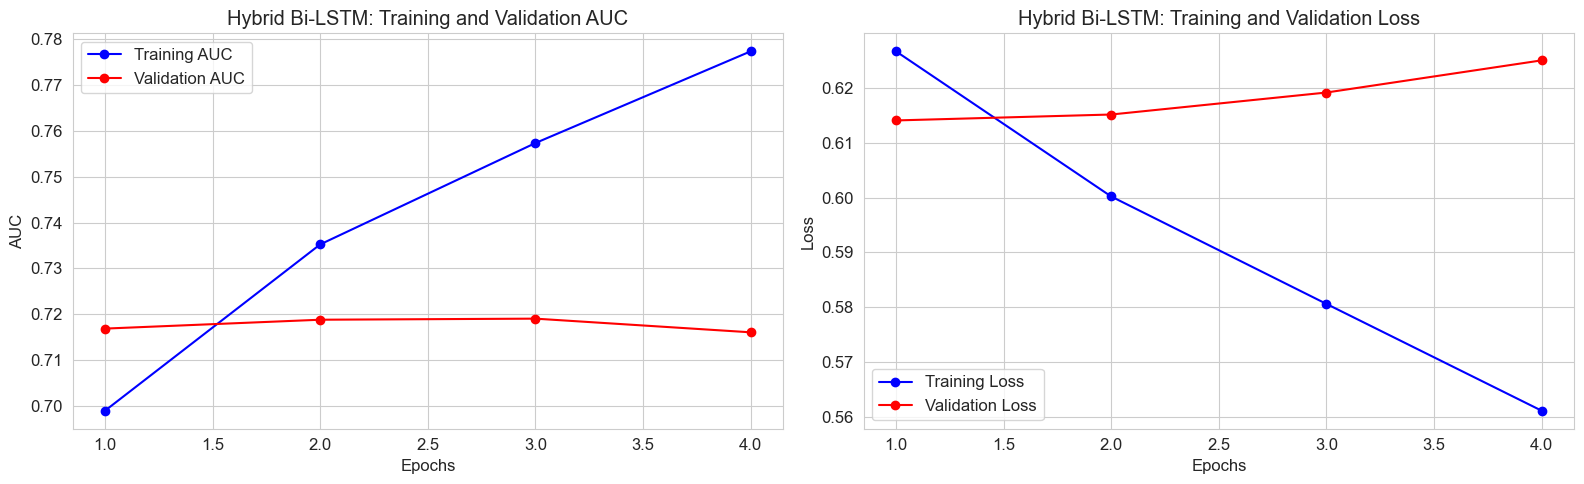

In [210]:
plot_training_history(history_bilstm, "Hybrid Bi-LSTM")

In [211]:
bilstm_scores = model_bilstm.predict(
    test_pipeline.map(lambda x, y: x),
    verbose=1
)

1142/1142 ━━━━━━━━━━━━━━━━━━━━ 200s 175ms/step


In [212]:
bilstm_test_data = test.loc[test_indices_with_valid_candidates].copy()

In [213]:
bilstm_test_data['score'] = bilstm_scores.flatten()

In [214]:
bilstm_metrics = bilstm_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)

/var/folders/__/bmtzjnxn039f2s779sjs1hhh0000gn/T/ipykernel_93012/1620667288.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bilstm_metrics = bilstm_test_data.groupby(['user_id', 'time']).apply(calculate_metrics)


In [215]:
bilstm_metrics.dropna(inplace=True)

In [216]:
bilstm_metrics_data = pd.DataFrame(bilstm_metrics.tolist(), columns=['AUC', 'MAP', 'NDCG@5', 'NDCG@10'])

In [217]:
bilstm_mean_metrics = bilstm_metrics_data.mean()

In [218]:
bilstm_mean_metrics

AUC        0.568387
MAP        0.230944
NDCG@5     0.242611
NDCG@10    0.306254
dtype: float64

In [219]:
evaluation_results['Hybrid Bi-LSTM'] = bilstm_mean_metrics

In [220]:
evaluation_results

{'Popularity': AUC        0.488288
 MAP        0.182673
 NDCG@5     0.198044
 NDCG@10    0.261494
 dtype: float64,
 'Content-Based': AUC        0.593417
 MAP        0.285850
 NDCG@5     0.296274
 NDCG@10    0.352968
 dtype: float64,
 'Content-Based (W2V)': AUC        0.504323
 MAP        0.134674
 NDCG@5     0.207861
 NDCG@10    0.268064
 dtype: float64,
 'SVD': AUC        0.555113
 MAP        0.205877
 NDCG@5     0.230172
 NDCG@10    0.292118
 dtype: float64,
 'Hybrid RNN': AUC        0.503991
 MAP        0.139351
 NDCG@5     0.210431
 NDCG@10    0.269755
 dtype: float64,
 'Hybrid LSTM': AUC        0.568548
 MAP        0.228526
 NDCG@5     0.241389
 NDCG@10    0.304908
 dtype: float64,
 'Hybrid Bi-LSTM': AUC        0.568387
 MAP        0.230944
 NDCG@5     0.242611
 NDCG@10    0.306254
 dtype: float64}

In [221]:
pd.DataFrame(evaluation_results).T

,AUC,MAP,NDCG@5,NDCG@10
Popularity,0.488288,0.182673,0.198044,0.261494
Content-Based,0.593417,0.285850,0.296274,0.352968
Content-Based (W2V),0.504323,0.134674,0.207861,0.268064
SVD,0.555113,0.205877,0.230172,0.292118
Hybrid RNN,0.503991,0.139351,0.210431,0.269755
Hybrid LSTM,0.568548,0.228526,0.241389,0.304908
Hybrid Bi-LSTM,0.568387,0.230944,0.242611,0.306254


### TRANSFORMER

In [222]:
MAX_TITLE_LEN = 20       
MAX_HISTORY_LEN = 30     
EMBEDDING_DIM = 100      
HEAD_NUM = 4             
HEAD_DIM = 32
DROPOUT_RATE = 0.2
NEG_SAMPLE_RATIO = 2     
BATCH_SIZE = 64          
EPOCHS = 3               
VOCAB_SIZE = 20000

In [223]:
def load_data():
    news = pd.read_csv('news.tsv', sep='\t', names=['id', 'cat', 'subcat', 'title', 'abs', 'url', 'tent', 'aent'], usecols=['id', 'title'])
    behaviors = pd.read_csv('behaviors.tsv', sep='\t', names=['imp_id', 'uid', 'time', 'hist', 'imp'], usecols=['time', 'hist', 'imp'])
    news['title'] = news['title'].fillna('')
    behaviors['hist'] = behaviors['hist'].fillna('')
    return news, behaviors

In [224]:
news, behaviors = load_data()

In [225]:
news_id_to_int = {nid: i+1 for i, nid in enumerate(news['id'])}
num_news = len(news_id_to_int) + 1

In [226]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(news['title'])

In [227]:
sequences = tokenizer.texts_to_sequences(news['title'])
padded_titles = pad_sequences(sequences, maxlen=MAX_TITLE_LEN, padding='post', truncating='post')

In [228]:
title_matrix = np.zeros((num_news, MAX_TITLE_LEN), dtype='int32')

In [229]:
for nid, seq in zip(news['id'], padded_titles):
    if nid in news_id_to_int:
        title_matrix[news_id_to_int[nid]] = seq
del news, sequences, padded_titles
gc.collect()

7249

In [230]:
behaviors['time'] = pd.to_datetime(behaviors['time'])
behaviors = behaviors.sort_values(by='time').reset_index(drop=True)

In [231]:
split_idx = int(len(behaviors) * 0.8)

In [232]:
train_df = behaviors.iloc[:split_idx]
test_df = behaviors.iloc[split_idx:]

In [233]:
def build_fast_dataset(df, is_training=True):
    histories = []
    candidates = []
    labels = []
    
    hist_col = df['hist'].values
    imp_col = df['imp'].values
    
    for hist_str, imp_str in zip(hist_col, imp_col):
        if pd.isna(hist_str) or hist_str == '':
            h_ids = []
        else:
            h_ids = [news_id_to_int.get(nid, 0) for nid in str(hist_str).split()]
            
        if len(h_ids) > MAX_HISTORY_LEN:
            h_ids = h_ids[-MAX_HISTORY_LEN:]
        else:
            h_ids = [0] * (MAX_HISTORY_LEN - len(h_ids)) + h_ids
        imps = str(imp_str).split()
        
        if is_training:
            positives = []
            negatives = []
            for item in imps:
                nid, label = item.split('-')
                n_int = news_id_to_int.get(nid, 0)
                if label == '1': positives.append(n_int)
                else: negatives.append(n_int)
            
            for pos in positives:
                histories.append(h_ids)
                candidates.append(pos)
                labels.append(1)
                
                if negatives:
                    sampled_negs = np.random.choice(negatives, min(len(negatives), NEG_SAMPLE_RATIO), replace=False)
                    for neg in sampled_negs:
                        histories.append(h_ids)
                        candidates.append(neg)
                        labels.append(0)
        else:
            for item in imps:
                nid, label = item.split('-')
                n_int = news_id_to_int.get(nid, 0)
                histories.append(h_ids)
                candidates.append(n_int)
                labels.append(int(label))
                
    return np.array(histories, dtype='int32'), np.array(candidates, dtype='int32'), np.array(labels, dtype='int32')


In [234]:
X_train_hist, X_train_cand, y_train = build_fast_dataset(train_df, is_training=True)

In [235]:
class AdditiveAttention(layers.Layer):
    def __init__(self, hidden_dim=128):
        super(AdditiveAttention, self).__init__()
        self.dense = layers.Dense(hidden_dim, activation='tanh')
        self.v = layers.Dense(1)

    def call(self, inputs):
        x = self.dense(inputs)
        weights = tf.nn.softmax(self.v(x), axis=1)
        return tf.reduce_sum(inputs * weights, axis=1)

In [236]:
def build_model():
    title_lookup = layers.Embedding(
        input_dim=num_news,
        output_dim=MAX_TITLE_LEN,
        weights=[title_matrix],
        trainable=False,
        name="Title_Lookup"
    )
    
    news_input = Input(shape=(MAX_TITLE_LEN,), dtype='int32')
    
    word_embedding = layers.Embedding(VOCAB_SIZE + 1, EMBEDDING_DIM)(news_input)
    word_embedding = layers.Dropout(DROPOUT_RATE)(word_embedding)
    
    mha_out = layers.MultiHeadAttention(num_heads=HEAD_NUM, key_dim=HEAD_DIM)(word_embedding, word_embedding)
    mha_out = layers.Dropout(DROPOUT_RATE)(mha_out)
    
    encoded = layers.Add()([word_embedding, mha_out])
    encoded = layers.LayerNormalization()(encoded)
    news_vec = AdditiveAttention(hidden_dim=128)(encoded)
    
    news_encoder = models.Model(inputs=news_input, outputs=news_vec, name="NewsEncoder")
    
    history_ids_input = Input(shape=(MAX_HISTORY_LEN,), dtype='int32', name="hist_ids")
    candidate_id_input = Input(shape=(1,), dtype='int32', name="cand_id")
    
    hist_titles = title_lookup(history_ids_input)
    cand_title = title_lookup(candidate_id_input)
    cand_title = layers.Reshape((MAX_TITLE_LEN,))(cand_title)

    cand_vec = news_encoder(cand_title)
    hist_vecs = layers.TimeDistributed(news_encoder)(hist_titles)

    user_mha = layers.MultiHeadAttention(num_heads=HEAD_NUM, key_dim=HEAD_DIM)(hist_vecs, hist_vecs)
    user_mha = layers.Dropout(DROPOUT_RATE)(user_mha)
    user_encoded = layers.Add()([hist_vecs, user_mha])
    user_encoded = layers.LayerNormalization()(user_encoded)
    user_vec = AdditiveAttention(hidden_dim=128)(user_encoded)
    
    score = layers.Dot(axes=1)([user_vec, cand_vec])
    output = layers.Activation('sigmoid')(score)
    
    return models.Model(inputs=[history_ids_input, candidate_id_input], outputs=output)


In [237]:
model = build_model()

In [238]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC(name='auc')])

In [239]:
history = model.fit(
    x=[X_train_hist, X_train_cand],
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=1, restore_best_weights=True)
    ]
)

Epoch 1/3
7798/7798 ━━━━━━━━━━━━━━━━━━━━ 7564s 967ms/step - auc: 0.6818 - loss: 0.6089 - val_auc: 0.6615 - val_loss: 0.6132
Epoch 2/3
7798/7798 ━━━━━━━━━━━━━━━━━━━━ 7821s 1s/step - auc: 0.7402 - loss: 0.5561 - val_auc: 0.6664 - val_loss: 0.6098
Epoch 3/3
7798/7798 ━━━━━━━━━━━━━━━━━━━━ 7866s 1s/step - auc: 0.7717 - loss: 0.5308 - val_auc: 0.6670 - val_loss: 0.6235


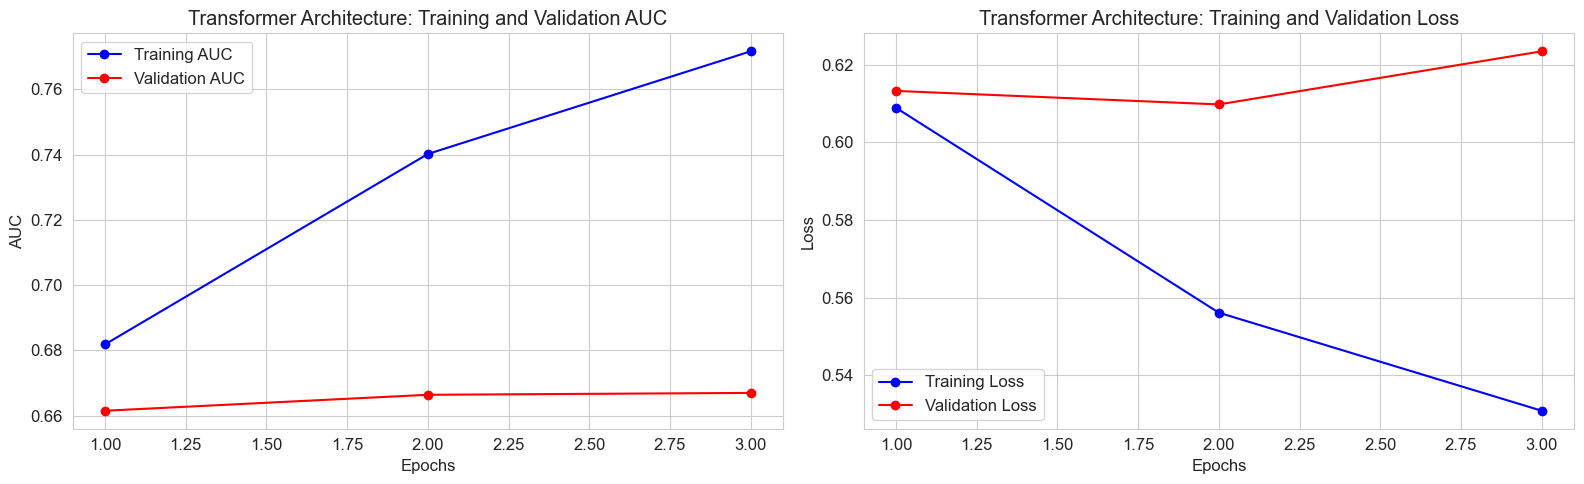

In [240]:
plot_training_history(history, "Transformer Architecture")

In [241]:
X_test_hist, X_test_cand, y_test = build_fast_dataset(test_df.iloc[:2000], is_training=False)

In [242]:
predictions = model.predict([X_test_hist, X_test_cand], batch_size=BATCH_SIZE, verbose=1)

1295/1295 ━━━━━━━━━━━━━━━━━━━━ 166s 118ms/step


In [243]:
roc_auc_score(y_test, predictions.flatten())

0.6478930476653819